In [39]:
import torch

In [55]:
x = tch.randn(1, requires_grad=True)
x

tensor([-0.1468], requires_grad=True)

In [56]:
print(x.grad)

None


In [57]:
y = x.sum()

In [58]:
y.backward()

In [44]:
print(x.grad)

tensor([1.])


In [45]:
# Set our random seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

Number of examples: 100
Number of features: 2


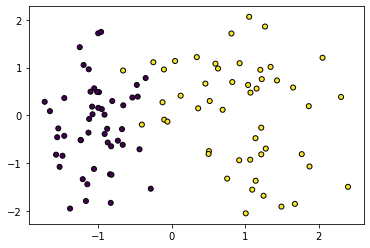

In [63]:
from sklearn.datasets import make_classification
set_seed(7)
X, Y = make_classification(n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1)
print('Number of examples: %d' % X.shape[0])
print('Number of features: %d' % X.shape[1])

# Take a peak
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=25, edgecolor='k')
plt.show()

In [64]:
# Convert data to PyTorch
X, Y = torch.from_numpy(X), torch.from_numpy(Y)

X, Y = X.float(), Y.float()

In [65]:
# Define dimensions
num_feats = 2
hidden_size = 100
num_outputs = 1

# Learning rate
eta = 0.1
num_steps = 1000

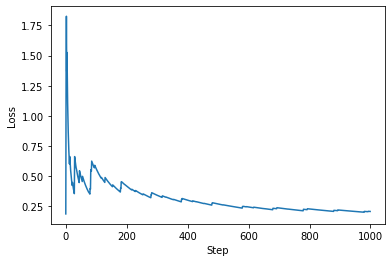

In [68]:
W1 = torch.randn(hidden_size, num_feats, requires_grad=True)
b1 = torch.zeros(hidden_size, requires_grad=True)

W2 = torch.randn(num_outputs, hidden_size, requires_grad=True)
b2 = torch.zeros(num_outputs, requires_grad=True)

parameters = [W1, b1, W2, b2]

indices = torch.randperm(X.size(0))

avg_loss = []


for step in range(num_steps):
    # get example
    i = indices[step % indices.size(0)]
    x_i, y_i = X[i], Y[i]
    
    # run example
    hidden = torch.relu(W1.matmul(x_i) + b1)
    y_hat = torch.sigmoid(W2.matmul(hidden) + b2)
    
    # compute loss binary cross entropy
    # epsilon for numeric stabulity
    eps = 1e-6
    loss = -(y_i * (y_hat + eps).log() + (1 - y_i) * (1 - y_hat + eps).log())
    
    if step == 0:
        avg_loss.append(loss.item())
    else:
        old_avg = avg_loss[-1]
        new_avg = (loss.item() + old_avg * len(avg_loss)) / (len(avg_loss) + 1)
        avg_loss.append(new_avg)
        
    # zero out all previous gradients
    for param in parameters:
       # it might start out as None
        if param.grad is not None:
            param.grad.zero_()
            
    # backward pass
    loss.backward()
    
    # update paramters
    for param in parameters:
        # in place
        param.data = param.data - eta * param.grad
        
plt.plot(range(num_steps), avg_loss)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

### torch.nn

### Layers

In [72]:
import torch.nn as nn

# linear layer: in_feat, out_feat
linear = nn.Linear(in_features=10, out_features=10)
print(linear)

# convolution layer: in channel, out channels, kernel_size, stride
conv = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
print(conv)

# RNN: num_inpnuts, num_hidden, num_layers
rnn = nn.RNN(input_size=10, hidden_size=10, num_layers=1)
print(rnn)

Linear(in_features=10, out_features=10, bias=True)
Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
RNN(10, 10)


In [74]:
print(linear.weight)
print([k for k,v in conv.named_parameters()])

Parameter containing:
tensor([[ 0.0148, -0.1137, -0.2674, -0.1787, -0.2336, -0.2009, -0.0984, -0.1076,
          0.0591, -0.3035],
        [ 0.1645,  0.1325,  0.0672,  0.0039, -0.1924, -0.2925, -0.0037,  0.0579,
          0.0255,  0.0336],
        [-0.2195,  0.2117, -0.2250,  0.2335, -0.2547, -0.2726, -0.0119, -0.1194,
         -0.2016, -0.2053],
        [ 0.2913, -0.2782,  0.0815,  0.2535,  0.1886,  0.2884,  0.0657, -0.2927,
         -0.1732,  0.0370],
        [-0.1063,  0.0385, -0.1573, -0.0819, -0.1728,  0.0328, -0.2432, -0.1218,
          0.1343, -0.0084],
        [ 0.2043, -0.1216,  0.2506, -0.0605,  0.0731, -0.1540,  0.1600,  0.0524,
          0.0792,  0.1853],
        [-0.0596, -0.3153, -0.0856, -0.0782,  0.2762,  0.0345,  0.1579,  0.1695,
         -0.0871, -0.0476],
        [ 0.2534,  0.2895, -0.0121,  0.3015,  0.0896,  0.2883, -0.0159,  0.1936,
          0.1377,  0.1947],
        [ 0.1584,  0.2060, -0.0106, -0.0631, -0.1440, -0.0705,  0.0313, -0.2952,
          0.2328,  0.2947

In [81]:
import torch.nn.functional as F

In [90]:
# Make our own model!

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input channel to 20 feature maps of 5x5 kernel. Stride 1.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        # Full connected of final 4x4 image to 500 features
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        
        # 500 to 10 classes
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

formula fro computing the sizes:

$$
W_f =\frac{W_i - F + 2p}{S} +1
$$

usually, $p = 0$:
$$
W_f =\frac{W_i - F}{S} +1
$$

if $F = S$:
$$
W_f =\frac{W_i }{S}
$$    

### Optimizers

In [91]:
import torch.optim as optim

# initialize with model parameters
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Full train and test loops

In [93]:
import tqdm
import torch.nn.functional as F

def train(model, train_loader, optimizer, epoch):
    
    model.train()
    
    # Avg_loss
    total_loss = 0
    
    #iterate through dataset
    for data, target in tqdm.tqdm(train_loader):
        # zero grad
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # negative log-likeihood loss function
        loss = F.nll_loss(output, target)
        
        # Backward pass
        loss.backward()
        total_loss += loss.item()
        
        # update
        optimizer.step()
        
    print("Train Epoch: {}\t Loss: {:.6f}".format(epoch, total_loss / len(train_loader)))

Testing loops are similar

In [99]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() #sum up bactch loss
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    

### MNIST
now running mnist

In [ ]:
from torchvision import datasets, transforms

# see the torch Dataloader for more details
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(    
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=32, shuffle=True)

for epoch in range(1, 10 + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)